# In this notebook, I explore the feasibility of chaining Machine Learning algorithms for dysarthric speech recognition.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import numpy as np
from scipy.io.wavfile import write
import os
from pathlib import Path
import csv

In [2]:
def trim_audio(x):
    middle = np.where(x == max(x[int(len(x)*0.1):int(len(x)*0.95)]))[0][0]
    minI, maxI = middle, middle
    while max(abs(x[minI:minI+500])) > 0.1:
        minI -= 50
    while max(abs(x[maxI-500:maxI])) > 0.1:
        maxI += 50
    return x[minI-500:maxI+1000] if minI > 500 else x[minI:maxI+1000]

In [3]:
def process_audio(fn):
    path = Path(fn)
    if fn == None:
        print("Not valid File")
    
    # checks to see if processed file already exists, and doesn't reprocess if it does
    if Path("/".join(path.parts[:-1])+"/.Processed/p"+path.name).is_file():
        file = "/".join(path.parts[:-1])+"/.Processed/p"+path.name
        time = librosa.get_duration(filename=file)
        return librosa.load(file, sr = int(4410/time))
        
    #loads and trims audio
    amplitudes, sr = librosa.load(fn)
    amplitudes = trim_audio(amplitudes)
    
    #creates a .Processed folder
    strdir = "/".join(path.parts[:-1])+"/.Processed/"
    try:
        os.mkdir(strdir)
    except:
        pass
        
    #saves the processed audio file into a new audio file in the .Processed folder
    newFilename = strdir + 'p' + path.name
    write(newFilename, sr, amplitudes)
    
    #loads audio file amplitude values that standardize the length of the amplitude array
    time = librosa.get_duration(filename=newFilename)
    amplitudes, sr = librosa.load(newFilename, sr = int(4410/time))
    return amplitudes, sr

In [4]:
def get_np_difs(np1, np2):
    #k-Nearest Neighbors (kNN) on rows and columns separately
    row_dif = np.sum(np.sqrt(np.sum(np.square(np1.copy()), axis = 1))) - np.sum(np.sqrt(np.sum(np.square(np2.copy()), axis = 1)))
    col_dif = np.sum(np.sqrt(np.sum(np.square(np1 - np2), axis = 0)))
    return row_dif, col_dif

In [5]:
def get_zero_crossing_dif(x1, x2):
    #finds difference in the number of zero crossings between audio files
    zero_crossings1 = librosa.zero_crossings(x1, pad=False)
    zero_crossings2 = librosa.zero_crossings(x2, pad=False)
    return sum(zero_crossings1) - sum(zero_crossings2)

In [6]:
def ridge_regression(row_dif, col_dif, zero_crossing_dif):
    #applies ridge regression on the difference in zero crossing and kNN analysis on rows
    #and columns, separately
    return row_dif**2 + col_dif**2 + zero_crossing_dif**2

In [7]:
def read_wordlist():
    #reads the wordlist csv into a dictionary for easy retrieval
    #Ex. CW100 corresponds to the word "Yes"
    with open('UASpeech/speaker_wordlist.csv', mode='r') as infile:
        reader = csv.reader(infile)
        word_dict = {rows[1]:rows[0] for rows in reader}
    del word_dict['FILE NAME']
    return word_dict

In [8]:
def get_word_from_filename(fn, word_dict):
    #retrievs the word based on the code used in the file
    path = Path(fn)
    fn = path.name.split('_')
    return word_dict[fn[2]]

In [9]:
def compare(person, i, word, first_word_filename, min_difs, min_file, amplitude1, sr1, mfcc1):
    #applies the chained ML algorithms on two audio files and returns the minimum difference
    #between the files and the file that is closes the the first_word_filename
    amplitude2, sr2, mfcc2 = np.array([]), 0, np.array([])

    filename = f"UASpeech/audio/{person}/{person}_B{i}_{word}_M5.wav"
    if not Path(filename).is_file():
        filename = f"UASpeech/audio/{person}/{person}_B{i}_{word}_M6.wav"
    try: 
        amplitude2, sr2 = process_audio(filename)
        mfcc2 = librosa.feature.mfcc(amplitude2, sr=sr2)
    except:
        return min_difs, min_file

    #doesn't compare audio files if the word lengths are too different
    if abs(len(amplitude1)/sr1 - len(amplitude2)/sr2) > 0.1:
        return min_difs, min_file
    difs = get_np_difs(mfcc1, mfcc2)
    ridge_dif = ridge_regression(difs[0], difs[1], get_zero_crossing_dif(amplitude1, amplitude2))
    if min_difs == None or min_difs > ridge_dif:
        min_difs = ridge_dif
        min_file = filename
        
    return min_difs, min_file

In [10]:
def get_accuracy_of_person(person):
    '''tests the word identification accuracy for 100 audio files for a specific person in database
    database is split into testing and training (second repetition of word is testing and 
    first and third are training) as per recommendation by owner of the databse'''
    total_accuracy = 0
    word_dict = read_wordlist()
    for w in range(1, 101):
        first_word_filename = f"UASpeech/audio/{person}/{person}_B2_CW{w}_M3.wav"
        if not Path(first_word_filename).is_file():
            first_word_filename = f"UASpeech/audio/"+person+"/"+person+"_B2_CW"+str(w)+"_M4.wav"
        word = get_word_from_filename(first_word_filename, word_dict)
        min_difs = None
        min_file = ""
        amplitude1, sr1 = process_audio(first_word_filename)
        mfcc1 = librosa.feature.mfcc(amplitude1, sr=sr1)
        
        #test accuracy for a single word by comparing it to 100 other audio files
        for wordnum in range(1, 101):
            for i in [1, 3]:
                min_difs, min_file = compare(person, i, "CW"+str(wordnum), first_word_filename, min_difs, min_file, amplitude1, sr1, mfcc1)

        total_accuracy += get_word_from_filename(min_file, word_dict) == word
    print(f"total_accuracy of {person} = {total_accuracy}%")
    return round(total_accuracy, 2)

Text(0, 0.5, 'Amplitude')

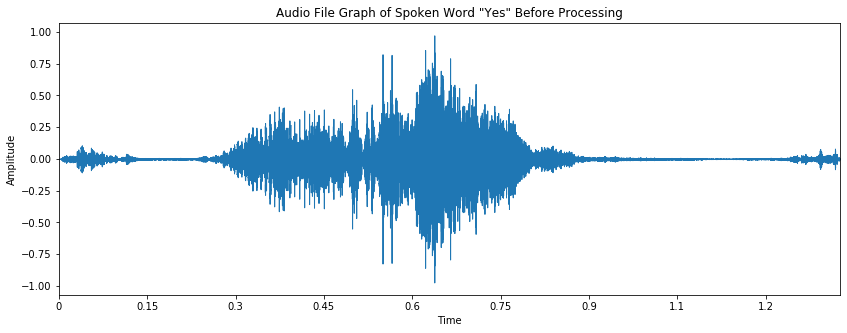

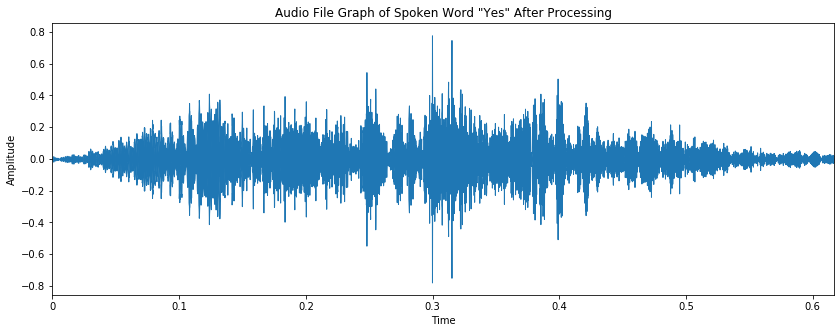

In [11]:
#Graph of wavform (Amplitude vs Time) before processing the audio file
x, sr = librosa.load("UASpeech/audio/M16/M16_B3_CW100_M4.wav")
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.title("Audio File Graph of Spoken Word \"Yes\" Before Processing")
plt.ylabel("Amplitude")

#Graph of wavform (Amplitude vs Time) after processing the audio file
x, sr = process_audio("UASpeech/audio/M16/M16_B3_CW100_M4.wav")
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.title("Audio File Graph of Spoken Word \"Yes\" After Processing")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Coefficient')

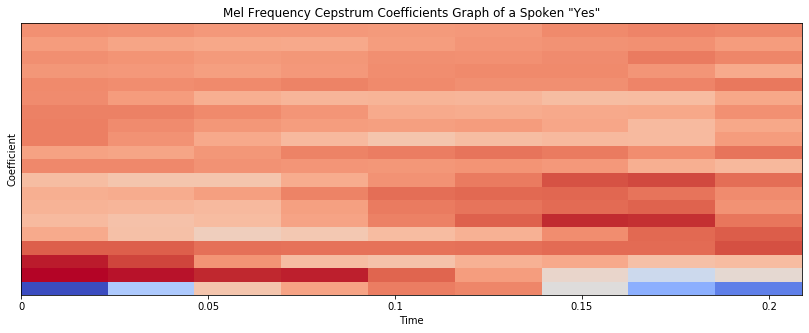

In [12]:
#Graph of Mel Frequency Cepstrum Coefficients (MFCC) of same audio file as the graphed 
#wavform above
x, sr = process_audio("UASpeech/audio/M16/M16_B3_CW100_M4.wav")
mfcc = librosa.feature.mfcc(x, sr=sr)
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc, x_axis='time')
plt.title("Mel Frequency Cepstrum Coefficients Graph of a Spoken \"Yes\"")
plt.ylabel("Coefficient")

In [13]:
%%timeit
for i in range(1, 101):
    process_audio(f"UASpeech/audio/M16/M16_B1_CW{i}_M3.wav")

767 ms ± 383 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#runs get_accuracy_of_person for each dysarthric speaker in the database
person_accuracy = {}
for person in os.listdir("UASpeech/audio/"):
    #try:
    person_accuracy[person] = get_accuracy_of_person(person)
    print(person_accuracy[person])
    #except:
    #    print(f"Error with {person}")
print(person_accuracy)